In [1]:
%matplotlib inline
from fastai.vision import *

In [8]:
# Dataset : kaggle competitions download -c yelp-restaurant-photo-classification
df_tptbi = pd.read_csv("train_photo_to_biz_ids.csv")
df_tptbi.head()
# df_tptbi.isna().sum()

,photo_id,business_id
0,204149,3034
1,52779,2805
2,278973,485
3,195284,485
4,19992,485


In [9]:
df_train = pd.read_csv("train.csv")
df_train.head()
# df_train.isna().sum()
# df_train["labels"].value_counts(dropna=False)[70:100]

,business_id,labels
0,1000,1 2 3 4 5 6 7
1,1001,0 1 6 8
2,100,1 2 4 5 6 7
3,1006,1 2 4 5 6
4,1010,0 6 8


In [10]:
#Jointure des deux dataset pour avoir les labels par image
df_tptbi=df_tptbi.merge(df_train,left_on="business_id",right_on="business_id") 

In [11]:
df_tptbid=df_tptbi.drop("business_id", axis=1)
df_tptbid.isna().sum() #Labels NaN à remplacer
# values = df_tptbid["labels"].value_counts(dropna=False) 
# values[70:100]

photo_id      0
labels      297
dtype: int64

In [12]:
dataf = df_tptbid.fillna("")

In [158]:
print(dataf.isna().sum())
print(dataf[dataf["labels"]==""].count())

photo_id    0
labels      0
dtype: int64

In [170]:
# dataf.info
# df_tptbid.info
dataf.dtypes

photo_id     int64
labels      object
dtype: object

In [4]:
chemin = Path("train_photos/")

In [160]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.) #A améliorer

In [176]:
np.random.seed(1024)
src = (ImageList.from_df(dataf,chemin, folder='.', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' ')) # On split les labels suivant un espace

In [177]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

In [7]:
# data.show_batch(rows=3, figsize=(12,9))

In [178]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, models.resnet18, metrics=[acc_02, f_score])

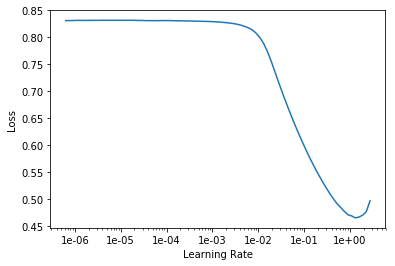

In [92]:
learn.lr_find()
learn.recorder.plot()

In [179]:
learn.fit_one_cycle(6, slice(3e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.514171,0.493281,0.661048,0.838892,13:51
1,0.525007,0.594311,0.671131,0.832271,13:48
2,0.515135,0.525020,0.678817,0.834273,14:07
3,0.493521,0.519772,0.684348,0.842793,14:05
4,0.479971,0.467501,0.682739,0.846070,13:59
5,0.472583,0.461861,0.681166,0.846750,13:37


In [180]:
learn.save('step1-RN18')

In [181]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


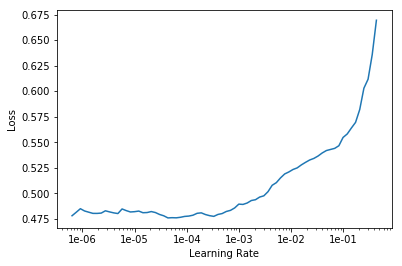

In [182]:
learn.lr_find()
learn.recorder.plot()

In [183]:
learn.fit_one_cycle(3, slice(5e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.462242,0.455579,0.691168,0.849084,13:45
1,0.451944,0.446136,0.702968,0.852927,13:53
2,0.444964,0.442197,0.702329,0.853397,13:43


In [184]:
learn.save('step2-RN18')

In [188]:
learn.export()

In [5]:
learn = load_learner(chemin, test=ImageList.from_folder('./test_photos'))

In [6]:
preds,y = learn.get_preds(ds_type=DatasetType.Test)
preds

tensor([[0.0632, 0.8878, 0.9477,  ..., 0.9868, 0.6703, 0.2998],
        [0.4057, 0.4069, 0.3738,  ..., 0.5508, 0.1318, 0.7211],
        [0.0989, 0.5946, 0.6173,  ..., 0.7999, 0.3088, 0.3220],
        ...,
        [0.5065, 0.2380, 0.2871,  ..., 0.3781, 0.0968, 0.8807],
        [0.3009, 0.2466, 0.2897,  ..., 0.4386, 0.1260, 0.7410],
        [0.3131, 0.3759, 0.4689,  ..., 0.7315, 0.1122, 0.6469]])

In [60]:
# Crée un dataframe avec les noms des photos et les prédictions (au format tensor)
submission = pd.DataFrame({'file': os.listdir('test_photos'), 'labels': preds}) 

In [52]:
submission.head()

,file,labels
0,204190.jpg,"(tensor(0.0632), tensor(0.8878), tensor(0.9477..."
1,115987.jpg,"(tensor(0.4057), tensor(0.4069), tensor(0.3738..."
2,419613.jpg,"(tensor(0.0989), tensor(0.5946), tensor(0.6173..."
3,101674.jpg,"(tensor(0.0283), tensor(0.9363), tensor(0.9721..."
4,356406.jpg,"(tensor(0.1979), tensor(0.6655), tensor(0.6572..."


In [89]:
df_test = pd.read_csv("test_photo_to_biz.csv")
df_test = df_test.astype(str) # Pour pouvoir faire la jointure plus tard
df_test.head(5)

,photo_id,business_id
0,317818,003sg
1,30679,003sg
2,455084,003sg
3,371381,003sg
4,86224,003sg


In [95]:
df_test["photo_id"].value_counts(dropna=False) # Pas mal de doublons de photos. Parfois pour des business différents

182938    16
235151    16
426819    16
91974     16
91600     15
221464    15
279986    15
404217    15
244853    15
24198     15
395184    15
449227    15
434693    15
252826    15
358824    15
7545      15
423182    14
88251     14
82675     14
360083    14
435552    14
116914    14
314336    14
322558    14
230477    14
267685    14
229721    14
271423    14
323622    14
223175    14
          ..
325185     1
117323     1
218320     1
267442     1
83098      1
4811       1
408519     1
231788     1
429321     1
60555      1
432549     1
97917      1
404742     1
344171     1
257554     1
304223     1
252947     1
60796      1
279049     1
138061     1
404420     1
122535     1
210876     1
244313     1
412909     1
53451      1
15982      1
159649     1
356068     1
257972     1
Name: photo_id, Length: 237152, dtype: int64

In [61]:
# On ne garde que les résultats par label dans une unique colonne label, séparés par des virgules
submission = submission.astype(str) # Pour pouvoir faire les replace
submission["labels"] = (submission["labels"]
              .str.replace('tensor',"") # Erreur quand 'tensor('. Cause non déterminée
              .str.replace(')',"")
              .str.replace('(',"")
              .str.replace(" ","")
             )
submission.head()

,file,labels
0,204190.jpg,"0.0632,0.8878,0.9477,0.5576,0.6093,0.9577,0.98..."
1,115987.jpg,"0.4057,0.4069,0.3738,0.4976,0.1454,0.6356,0.55..."
2,419613.jpg,"0.0989,0.5946,0.6173,0.4808,0.5469,0.7630,0.79..."
3,101674.jpg,"0.0283,0.9363,0.9721,0.4414,0.8247,0.9795,0.99..."
4,356406.jpg,"0.1979,0.6655,0.6572,0.4072,0.3576,0.8759,0.84..."


In [69]:
# On split dans un nouveau Df la colonne labels en 9 colonnes, sur les ","
mew = submission["labels"].str.split(",", n = 8, expand = True).astype(float) 
mew.head(3)

,0,1,2,3,4,5,6,7,8
0,0.0632,0.8878,0.9477,0.5576,0.6093,0.9577,0.9868,0.6703,0.2998
1,0.4057,0.4069,0.3738,0.4976,0.1454,0.6356,0.5508,0.1318,0.7211
2,0.0989,0.5946,0.6173,0.4808,0.5469,0.7630,0.7999,0.3088,0.3220


In [71]:
mew.dtypes

0    float64
1    float64
2    float64
3    float64
4    float64
5    float64
6    float64
7    float64
8    float64
dtype: object

In [76]:
# On rajoute ces colonnes dans le Df original
for i in range(9):
    submission[f"{i}"]=mew[i]
    

In [79]:
submission.head()

,file,labels,0,1,2,3,4,5,6,7,8
0,204190.jpg,"0.0632,0.8878,0.9477,0.5576,0.6093,0.9577,0.98...",0.0632,0.8878,0.9477,0.5576,0.6093,0.9577,0.9868,0.6703,0.2998
1,115987.jpg,"0.4057,0.4069,0.3738,0.4976,0.1454,0.6356,0.55...",0.4057,0.4069,0.3738,0.4976,0.1454,0.6356,0.5508,0.1318,0.7211
2,419613.jpg,"0.0989,0.5946,0.6173,0.4808,0.5469,0.7630,0.79...",0.0989,0.5946,0.6173,0.4808,0.5469,0.7630,0.7999,0.3088,0.3220
3,101674.jpg,"0.0283,0.9363,0.9721,0.4414,0.8247,0.9795,0.99...",0.0283,0.9363,0.9721,0.4414,0.8247,0.9795,0.9951,0.6550,0.1145
4,356406.jpg,"0.1979,0.6655,0.6572,0.4072,0.3576,0.8759,0.84...",0.1979,0.6655,0.6572,0.4072,0.3576,0.8759,0.8484,0.2675,0.3769


In [80]:
submission.drop(columns =["labels"], inplace = True)
submission.head()

,file,0,1,2,3,4,5,6,7,8
0,204190.jpg,0.0632,0.8878,0.9477,0.5576,0.6093,0.9577,0.9868,0.6703,0.2998
1,115987.jpg,0.4057,0.4069,0.3738,0.4976,0.1454,0.6356,0.5508,0.1318,0.7211
2,419613.jpg,0.0989,0.5946,0.6173,0.4808,0.5469,0.7630,0.7999,0.3088,0.3220
3,101674.jpg,0.0283,0.9363,0.9721,0.4414,0.8247,0.9795,0.9951,0.6550,0.1145
4,356406.jpg,0.1979,0.6655,0.6572,0.4072,0.3576,0.8759,0.8484,0.2675,0.3769


In [82]:
submission["file"] =submission["file"].str.replace('.jpg',"")
submission.head()


,file,0,1,2,3,4,5,6,7,8
0,204190,0.0632,0.8878,0.9477,0.5576,0.6093,0.9577,0.9868,0.6703,0.2998
1,115987,0.4057,0.4069,0.3738,0.4976,0.1454,0.6356,0.5508,0.1318,0.7211
2,419613,0.0989,0.5946,0.6173,0.4808,0.5469,0.7630,0.7999,0.3088,0.3220
3,101674,0.0283,0.9363,0.9721,0.4414,0.8247,0.9795,0.9951,0.6550,0.1145
4,356406,0.1979,0.6655,0.6572,0.4072,0.3576,0.8759,0.8484,0.2675,0.3769


In [86]:
df_res = pd.read_csv("sample_submission.csv")
df_res.head()

,business_id,labels
0,003sg,1 2 3
1,00er5,1 2 3
2,00kad,1 2 3
3,00mc6,1 2 3
4,00q7x,1 2 3


In [90]:
# On merge avec df_test pour rajouter les business id par image
submissionMerged=submission.merge(df_test,left_on="file",right_on="photo_id")
submissionMerged.head()

,file,0,1,2,3,4,5,6,7,8,photo_id,business_id
0,204190,0.0632,0.8878,0.9477,0.5576,0.6093,0.9577,0.9868,0.6703,0.2998,204190,60aoe
1,204190,0.0632,0.8878,0.9477,0.5576,0.6093,0.9577,0.9868,0.6703,0.2998,204190,86orh
2,204190,0.0632,0.8878,0.9477,0.5576,0.6093,0.9577,0.9868,0.6703,0.2998,204190,8bvzw
3,204190,0.0632,0.8878,0.9477,0.5576,0.6093,0.9577,0.9868,0.6703,0.2998,204190,gtpie
4,115987,0.4057,0.4069,0.3738,0.4976,0.1454,0.6356,0.5508,0.1318,0.7211,115987,6sh64


In [94]:
submissionMerged["photo_id"].value_counts(dropna=False) # On retrouve bien des résultats identiques à précédemment

182938    16
91974     16
426819    16
235151    16
244853    15
434693    15
7545      15
252826    15
91600     15
395184    15
449227    15
24198     15
221464    15
404217    15
358824    15
279986    15
411286    14
82675     14
321492    14
118178    14
172471    14
360083    14
372551    14
267685    14
196519    14
147997    14
328971    14
115995    14
314336    14
115097    14
          ..
365940     1
470959     1
452954     1
379101     1
239827     1
427628     1
282382     1
35400      1
276374     1
115423     1
148170     1
396811     1
85043      1
462336     1
269415     1
127749     1
278610     1
114808     1
368673     1
197288     1
274242     1
217811     1
377094     1
200444     1
76851      1
163661     1
456733     1
307521     1
394767     1
223300     1
Name: photo_id, Length: 237152, dtype: int64

In [288]:
# On fusionne toutes les résultats pour chaque image par business, en faisant la moyenne de leur coefficient de classe
sub = submissionMerged.groupby('business_id', as_index=False)['0','1','2','3','4','5','6','7','8'].mean()

In [289]:
sub["8"].mean()


0.5335045962340331

In [290]:
sub["labels"]=""
sub.head()

,business_id,0,1,2,3,4,5,6,7,8,labels
0,003sg,0.230201,0.596807,0.640554,0.484940,0.432625,0.727936,0.778322,0.382711,0.503943,
1,00er5,0.239906,0.571340,0.629270,0.502097,0.389818,0.732717,0.772937,0.355109,0.537914,
2,00kad,0.251537,0.547811,0.585824,0.493882,0.379825,0.692566,0.731217,0.333190,0.537440,
3,00mc6,0.247113,0.585420,0.617900,0.459667,0.407160,0.712600,0.725760,0.323447,0.531580,
4,00q7x,0.212383,0.563004,0.605767,0.464771,0.385029,0.690475,0.814358,0.340313,0.529050,


In [291]:
# Liste de classes et de moyenne des par classe
col = ['0','1','2','3','4','5','6','7','8']
submean= []
for i in col:
    submean.append(sub[i].mean())
submean

[0.23943684791202982,
 0.5707981776395199,
 0.6195639355085326,
 0.4873873927432276,
 0.3930237522094305,
 0.7166923844320545,
 0.7643641784720201,
 0.3468368335056371,
 0.5335045962340331]

In [292]:
# On ajoute dans la colonne labels les classes qui soient dépenssent un seuil prédéfini, soit dépassent la moyenne de chaque classe
tresh = 0.49
for index, row in sub.iterrows():
    j=0
    for i in col:
        if row[i] > submean[j]:
        #if row[i] > tresh:    
            sub.at[index, 'labels'] = str(sub.at[index, 'labels']) + " " + i
        if j < 9:
            j+=1





In [293]:
sub.head()

,business_id,0,1,2,3,4,5,6,7,8,labels
0,003sg,0.230201,0.596807,0.640554,0.484940,0.432625,0.727936,0.778322,0.382711,0.503943,1 2 4 5 6 7
1,00er5,0.239906,0.571340,0.629270,0.502097,0.389818,0.732717,0.772937,0.355109,0.537914,0 1 2 3 5 6 7 8
2,00kad,0.251537,0.547811,0.585824,0.493882,0.379825,0.692566,0.731217,0.333190,0.537440,0 3 8
3,00mc6,0.247113,0.585420,0.617900,0.459667,0.407160,0.712600,0.725760,0.323447,0.531580,0 1 4
4,00q7x,0.212383,0.563004,0.605767,0.464771,0.385029,0.690475,0.814358,0.340313,0.529050,6


In [294]:
# Un aperçu des classes et de leurs fréquences
# sub["labels"].describe()
sub["labels"].value_counts(dropna=False) 

 1 2 4 5 6 7        3144
 0 3 8              1521
 1 2 3 4 5 6 7      1509
 0 8                 876
 6 8                 152
 0 6 8               102
 1 2 4 5 6            97
 1 2 3 4 5 7          90
 8                    78
 1 2 4 5 7            75
 0 1 2 4 5 6 7        71
 0 1 2 3 4 5 7        67
 0 3 6 8              65
 1 2 3 5 6            63
 3 8                  62
 0 3 5 8              60
 1 2 5 6 8            54
 0 1 2 3 4 5 6 7      52
 1 2 4 6 7            50
 3 6 8                46
 0 1 2 5 6 8          43
 1 2 3 4 5 6          42
 1 2 4 5 6 7 8        39
 0 1 2 4 5 7          39
 1 2 5 6              38
 2 3 5 6 8            33
 0 3 4 7              31
 0 1 2 3 5 6 8        31
 0 3 7 8              31
 0 1 2 4 7            28
                    ... 
 2 3 4 6 8             1
 4 5                   1
 0 2 4 5 6 7 8         1
 1 2 3 4 5 6 8         1
 0 1 5 7 8             1
 1 2 4 5 7 8           1
 2 4 7                 1
 2 3 5 7               1
 0 1 3 4               1


In [295]:
sub.drop(columns =['0','1','2','3','4','5','6','7','8'], inplace = True)

In [296]:
# Df final
sub.head()

,business_id,labels
0,003sg,1 2 4 5 6 7
1,00er5,0 1 2 3 5 6 7 8
2,00kad,0 3 8
3,00mc6,0 1 4
4,00q7x,6


In [297]:
#On enregistre le Df en .csv
sub.to_csv('sample_submissionmean.csv', index=False)

In [234]:
#Scores on Kaggle with regards to treshold :
# 0.20 : 0.67447
# 0.40 : 0.75810
# 0.45 : 0.77539
# 0.48 : 0.78647
# 0.49 : 0.78471
# 0.50 : 0.78660
# 0.52 : 0.77694
# 0.55 : 0.75934
# 0.60 : 0.71806
# 0.66 : 0.67792
# mean : 0.75367